<a href="https://colab.research.google.com/github/mahikabhartari/BA820-Project-News-Article-Text-Analysis/blob/main/Combined_Project_EDA_Mahika%26Rajashree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [61]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
df = pd.read_csv('/content/drive/MyDrive/Copy of news_random_strat_pub_5perc.csv')

In [64]:
#printing head of the dataframe
df.head()

,date,year,month,day,author,title,article,url,section,publication,random,rowcnt
0,2020-02-26 00:00:00 UTC,2020,2,26,Alex Pareene,The Selling of the Democratic Primary,The Democratic Party has a monopoly on a produ...,https://newrepublic.com/article/156676/selling...,NaN,New Republic,01beb405-44d2-4c8a-8e49-09a54ae97be8,6
1,2020-02-19 00:00:00 UTC,2020,2,19,Alex Shephard,How Michael Bloomberg Owned New York Media,Not long after he began contemplating running ...,https://newrepublic.com/article/156612/michael...,NaN,New Republic,02fc2a43-bf35-4bd1-a280-fb449c932df9,12
2,2020-02-12 00:00:00 UTC,2020,2,12,Walter Shapiro,The Media’s Lousy Election Analysis Is Damagin...,Like compulsive gamblers who react to every lo...,https://newrepublic.com/article/156558/medias-...,NaN,New Republic,05b53699-bd95-4e07-8ef3-ec06f81f322d,26
3,2020-02-14 00:00:00 UTC,2020,2,14,Libby Watson,Can Corporate America Get Behind Medicare for ...,"A few days before Christmas in 2007, Wendell P...",https://newrepublic.com/article/156381/wendell...,NaN,New Republic,08ef5585-f686-4fed-9ea7-6f11acd42f58,39
4,2020-02-25 00:00:00 UTC,2020,2,25,Kate Knibbs,Let's Have the GIF Pronunciation Debate Forever,Looking at the internet can often feel like ea...,https://www.wired.com/story/the-great-debate-g...,culture,Wired,0117cc64-5675-4632-90a2-f247c8983f24,13


In [65]:
# number of rows and columns
df.shape

(85753, 12)

In [66]:
#seeing the datatypes
df.dtypes

date           object
year            int64
month           int64
day             int64
author         object
title          object
article        object
url            object
section        object
publication    object
random         object
rowcnt          int64
dtype: object

In [67]:
#checking for null values
df.isna().sum()

date               0
year               0
month              0
day                0
author         26910
title              0
article         3851
url                0
section        29735
publication        0
random             0
rowcnt             0
dtype: int64

In [68]:
#dropping null values from the og dataframe
df.dropna(subset=['article'], inplace=True)

In [69]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
85748    False
85749    False
85750    False
85751    False
85752    False
Length: 81902, dtype: bool

In [70]:
df.duplicated().value_counts()

False    81902
dtype: int64

In [71]:
#number of duplicates in url
df.duplicated(subset=['url']).sum()

0

In [72]:
#number of duplicates in title
df.duplicated(subset=['title']).sum()

692

In [73]:
# checking for duplicates in the "title" column (sanity check)
duplicate_titles = df[df.duplicated(subset=['title'], keep=False)]
duplicate_titles

,date,year,month,day,author,title,article,url,section,publication,random,rowcnt
637,2017-02-21 00:00:00 UTC,2017,2,21,Gizmodo Staff,Gizmodo,Have something you think we should know? You c...,https://gizmodo.com/hey-remember-you-can-email...,NaN,Gizmodo,0aeba780-3121-49c0-9309-43ea03764136,41
643,2019-02-08 00:00:00 UTC,2019,2,8,Deena ElGenaidi,A View From the Easel,"This week, artist studios in Barbados, Califor...",https://hyperallergic.com/483891/a-view-from-t...,NaN,Hyperallergic,00f1cc16-5612-4135-98a7-6200fdc4f87c,53
694,2016-02-02 00:00:00 UTC,2016,2,2,Matt Stromberg,ArtRx LA,Advertise on Hyperallergic with Nectar Ads LOS...,https://hyperallergic.com/272308/artrx-la-80/,NaN,Hyperallergic,09da5ccb-163d-47a7-8c0c-cb6e9d7db47d,512
716,2016-02-05 00:00:00 UTC,2016,2,5,NaN,What's the Big Frigin' Difference?!,Greg Olsen is all business on the field as the...,https://www.tmz.com/2016/02/05/whats-the-big-f...,NaN,TMZ,00de0de1-3389-4e43-a39d-26327d96cb7c,153
721,2020-02-22 00:00:00 UTC,2020,2,22,NaN,Stars and Scars -- You Be the Judge,Kobe and Gigi Bryant's memorial at Staples Cen...,https://www.tmz.com/2020/02/22/polls-you-be-th...,NaN,TMZ,01134bd0-bce7-43c7-bcca-5175987b0ea5,193
...,...,...,...,...,...,...,...,...,...,...,...,...
85617,2018-01-30 14:39:57 UTC,2018,1,30,Rosalie R. Radomsky,Recent Commercial Real Estate Transactions,$4.9 MILLION 340 Walton Avenue (at East 140th ...,https://www.nytimes.com/2018/01/30/realestate/...,realestate,The New York Times,0188e583-4040-477f-903c-6717fe90da6e,1514
85639,2016-01-14 20:34:24 UTC,2016,1,14,Matt Flegenheimer,What You Missed in the Debate,Following is immediate analysis of the sixth R...,http://www.nytimes.com/2016/01/15/us/politics/...,us,The New York Times,01c41331-92a0-40c3-bf98-5815591d3aab,1715
85685,2016-01-29 13:57:52 UTC,2016,1,29,NaN,Homes for Sale in New York and New Jersey,On the Market 16 Photos View Slide Show › Clic...,http://www.nytimes.com/2016/01/31/realestate/h...,realestate,The New York Times,024976f5-c542-4574-b959-c71eccd59973,2236
85700,2020-01-16 22:55:10 UTC,2020,1,16,"Michael D. Shear, Emily Cochrane, Sheryl Gay S...",Day in Impeachment: House Moves Articles to th...,The delivery of the articles of impeachment on...,https://www.nytimes.com/live/2020/trump-impeac...,NaN,The New York Times,026ae3ad-96b5-42fe-b669-60ab0724fc77,2364


In [74]:
#counting occurrences of each duplicate title
duplicate_titles_only = duplicate_titles['title']
duplicate_titles_only.value_counts()

The VICE Morning Bulletin                                                                          30
Quotation of the Day                                                                               24
Stars and Scars -- You Be the Judge                                                                17
Deals of the day-Mergers and acquisitions                                                          15
8 Things You Need To Know This AM                                                                  15
                                                                                                   ..
The Week in Books                                                                                   2
Las principales noticias del martes                                                                 2
Felicity Huffman and Lori Loughlin Appear in Court as College Admissions Scandal Rewrites Lives     2
Atlanta Braves - PlayerWatch                                                      

In [75]:
#checking duplicates for articles as the same titled articles could belong to different timeline
df.duplicated(subset=['article']).sum()


488

In [76]:
#dropping duplicates
df.drop_duplicates(subset=['article'], inplace=True)

In [77]:
#printing unique number of authors, sections, publications, year
df['author'].unique()

array(['Alex Pareene', 'Alex Shephard', 'Walter Shapiro', ...,
       'Julie Bosman, Monica Davey', 'Katla McGlynn', 'Orhan Pamuk'],
      dtype=object)

In [78]:
df['section'].unique()

array([nan, 'culture', 'transportation', 'gear', 'security', 'science',
       'business', 'ideas', 'europe', 'special-report', 'graphic-detail',
       'middle-east-and-africa', 'britain', 'gulliver', 'the-americas',
       'prospero', 'science-and-technology', 'asia',
       'the-world-this-week', 'united-states', 'international', 'china',
       'books-and-arts', 'bagehots-notebook', 'leaders',
       'finance-and-economics', 'free-exchange', 'briefing', 'letters',
       'the-economist-explains', 'democracy-in-america',
       'technology-quarterly', 'buttonwoods-notebook', 'Policy', 'Gaming',
       'Google', 'Entertainment', 'Tech', 'Science', 'Interview', 'Apple',
       'Podcasts', 'US & World', 'Transportation', 'Hands-on',
       'Watch This', 'Design', 'Apps', 'Mobile', 'Reviews', 'TL;DR',
       'Report', 'Microsoft', 'Business', 'Featured Videos', 'Good Deals',
       'Web', 'Movie Review', 'Smart Home', 'Exclusive', 'New Adventures',
       'The Interface', 'From the Stra

In [79]:
df['year'].unique()

array([2020, 2019, 2016, 2017, 2018])

In [80]:
author_value_counts = df['author'].value_counts()
author_counts_df = author_value_counts.reset_index()
author_counts_df.columns = ['Author', 'Count']
author_counts_df

,Author,Count
0,Field Level Media,315
1,The Associated Press,294
2,Axios,245
3,Dave Quinn,244
4,Karen Mizoguchi,224
...,...,...
13806,"Barak Goodman, Jamila Ephron, Glenn Kenny, Bar...",1
13807,Ibram X. Kendi,1
13808,Katya Cengel,1
13809,Romila Thapar,1


In [81]:
df['title'].unique()

array(['The Selling of the Democratic Primary',
       'How Michael Bloomberg Owned New York Media',
       'The Media’s Lousy Election Analysis Is Damaging Political Discourse',
       ..., 'Hyde Park, N.Y.: A Gilded Age Getaway With a Friendly Vibe',
       'Mark Salling, Former ‘Glee’ Star, Is Found Dead',
       'Word + Quiz: haggard'], dtype=object)

In [82]:
title_value_counts = df['title'].value_counts()
title_counts_df = title_value_counts.reset_index()
title_counts_df.columns = ['Title', 'Count']
title_counts_df

,Title,Count
0,The VICE Morning Bulletin,30
1,Quotation of the Day,24
2,Stars and Scars -- You Be the Judge,17
3,8 Things You Need To Know This AM,15
4,Recent Commercial Real Estate Transactions,15
...,...,...
80920,Uber's China Problem,1
80921,Neuroscientists Are Searching for God in Our G...,1
80922,How to Make Medicinal Honey Wine in the Middle...,1
80923,New Stem Cell Discovery Could Boost Corn Crop ...,1


In [83]:
df['section'].unique()

array([nan, 'culture', 'transportation', 'gear', 'security', 'science',
       'business', 'ideas', 'europe', 'special-report', 'graphic-detail',
       'middle-east-and-africa', 'britain', 'gulliver', 'the-americas',
       'prospero', 'science-and-technology', 'asia',
       'the-world-this-week', 'united-states', 'international', 'china',
       'books-and-arts', 'bagehots-notebook', 'leaders',
       'finance-and-economics', 'free-exchange', 'briefing', 'letters',
       'the-economist-explains', 'democracy-in-america',
       'technology-quarterly', 'buttonwoods-notebook', 'Policy', 'Gaming',
       'Google', 'Entertainment', 'Tech', 'Science', 'Interview', 'Apple',
       'Podcasts', 'US & World', 'Transportation', 'Hands-on',
       'Watch This', 'Design', 'Apps', 'Mobile', 'Reviews', 'TL;DR',
       'Report', 'Microsoft', 'Business', 'Featured Videos', 'Good Deals',
       'Web', 'Movie Review', 'Smart Home', 'Exclusive', 'New Adventures',
       'The Interface', 'From the Stra

In [84]:
section_value_counts = df['section'].value_counts()
section_counts_df = section_value_counts.reset_index()
section_counts_df.columns = ['Section', 'Count']
section_counts_df

,Section,Count
0,World News,3396
1,Business News,2784
2,Market News,2134
3,us,1994
4,Wires,1821
...,...,...
993,Natural Disasters,1
994,Floods,1
995,Oklahoma,1
996,Hearings,1


In [85]:
df['publication'].unique()

array(['New Republic', 'Wired', 'Washington Post', 'Gizmodo',
       'Hyperallergic', 'TMZ', 'Economist', 'Vice News', 'Axios',
       'The Verge', 'Politico', 'The Hill', 'Buzzfeed News', 'CNBC',
       'Mashable', 'CNN', 'TechCrunch', 'Vox', 'Business Insider',
       'The New York Times', 'People', 'Reuters', 'Vice', 'Refinery 29',
       'Fox News', 'New Yorker'], dtype=object)

In [86]:
publication_value_counts = df['publication'].value_counts()
publication_counts_df = publication_value_counts.reset_index()
publication_counts_df.columns = ['Publication', 'Count']
publication_counts_df

,Publication,Count
0,Reuters,21864
1,The New York Times,12289
2,People,6695
3,Vice,5037
4,Refinery 29,4292
5,CNBC,3429
6,Business Insider,2894
7,CNN,2851
8,Mashable,2616
9,TechCrunch,2597


FURTHER ANALYSIS OF THE DATA

In [87]:
#groupping by authors to see the number of articles written by them
articles_by_publication = df.groupby('publication').size().reset_index(name='num_articles')

#calculating the average word count per article for each author
avg_word_count = df.groupby('publication')['article'].apply(lambda x: x.str.split().str.len().mean()).reset_index(name='avg_word_count')

#merging the two dataframes
publication_contribution = pd.merge(articles_by_publication, avg_word_count, on='publication')


In [88]:
#publication v/s articles
publication_contribution_sorted = publication_contribution.sort_values(by='num_articles', ascending=False)
publication_contribution_sorted


,publication,num_articles,avg_word_count
15,Reuters,21864,304.358077
19,The New York Times,12289,931.749451
12,People,6695,426.836594
21,Vice,5037,769.168751
14,Refinery 29,4292,469.894688
3,CNBC,3429,430.720910
1,Business Insider,2894,768.438839
4,CNN,2851,657.117503
9,Mashable,2616,459.675841
17,TechCrunch,2597,557.323450


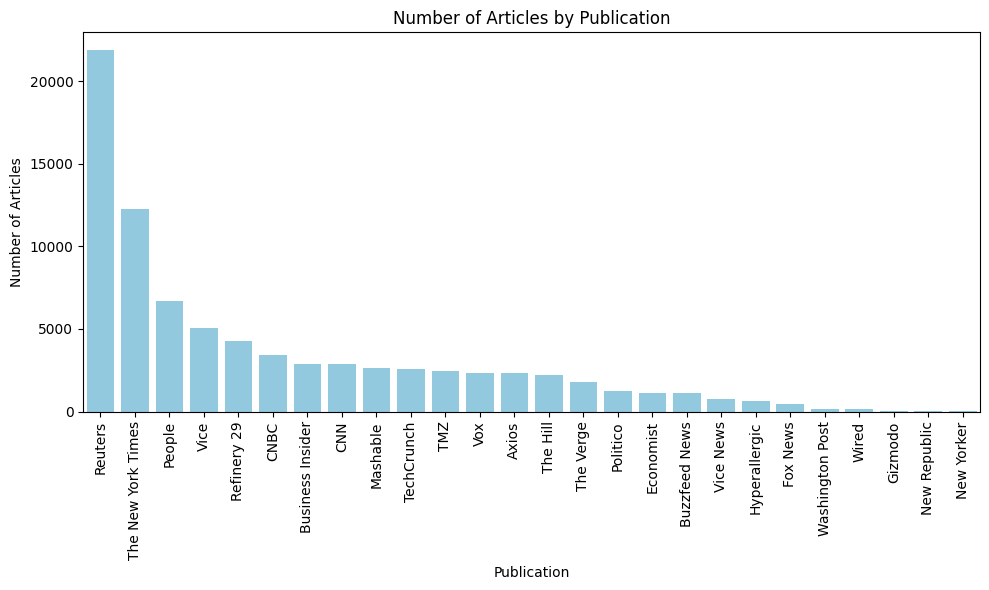

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

#bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='publication', y= 'num_articles', data= publication_contribution_sorted, color= 'skyblue')
plt.title('Number of Articles by Publication')
plt.xlabel('Publication')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [90]:
#publication vs avg word count
publication_avgword_sorted = publication_contribution.sort_values(by='avg_word_count', ascending=False)
publication_avgword_sorted

,publication,num_articles,avg_word_count
11,New Yorker,25,1876.200000
10,New Republic,42,1720.785714
23,Vox,2361,1161.048708
25,Wired,133,1103.300752
19,The New York Times,12289,931.749451
2,Buzzfeed News,1103,885.511333
8,Hyperallergic,662,813.779456
22,Vice News,776,808.256443
5,Economist,1127,807.694765
21,Vice,5037,769.168751


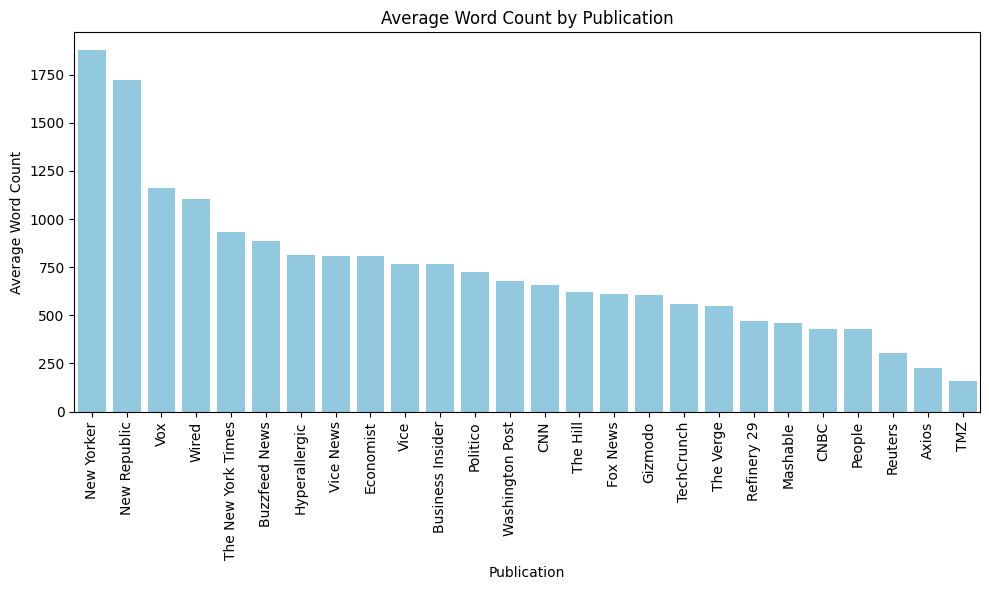

In [91]:
# publication vs avg word count
plt.figure(figsize=(10, 6))
sns.barplot( x= 'publication', y='avg_word_count', data= publication_avgword_sorted, color= 'skyblue')
plt.title('Average Word Count by Publication')
plt.xlabel('Publication')
plt.ylabel('Average Word Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [92]:
#groupping by 'section' and count the number of articles in each section
section_distribution = df.groupby('section').size().reset_index(name='num_articles')

#sorting sections by the number of articles in descending order
section_distribution_sorted = section_distribution.sort_values(by='num_articles', ascending=False)
top_10_sections = section_distribution_sorted.head(10)
top_10_sections

,section,num_articles
604,World News,3396
89,Business News,2784
330,Market News,2134
963,us,1994
599,Wires,1821
993,world,1455
856,opinion,1370
872,politics,1266
214,Financials,1209
955,tv,1207


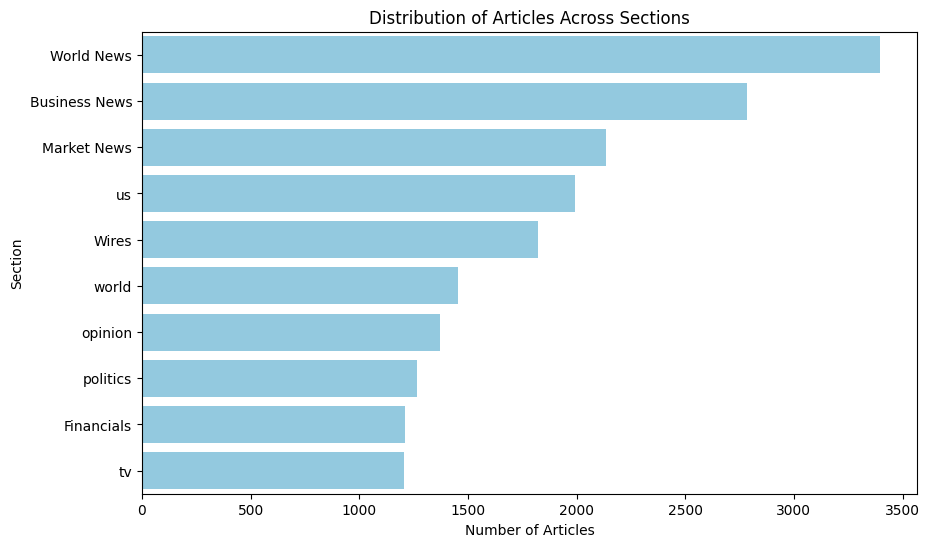

In [93]:
import seaborn as sns
#plotting distribution of articles across sections
plt.figure(figsize=(10, 6))
sns.barplot(x='num_articles', y='section', data=top_10_sections, color= 'skyblue')
plt.title('Distribution of Articles Across Sections')
plt.xlabel('Number of Articles')
plt.ylabel('Section')
plt.show()

In [94]:
#time series

#extracting year from 'date' column
#df['year'] = df['date'].dt.year

#groupping by 'year' and count the number of articles for each year
articles_by_year = df.groupby('year').size()

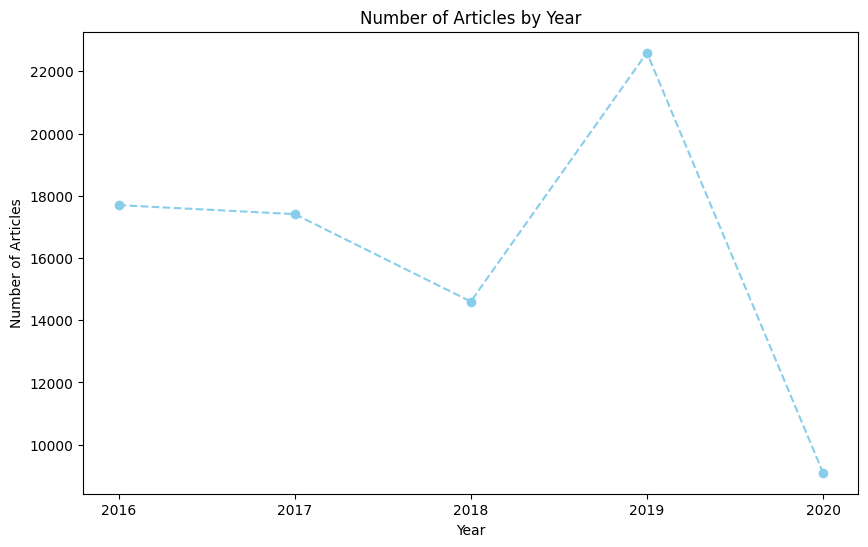

In [95]:
# plotting line chart
plt.figure(figsize=(10, 6))
plt.plot(articles_by_year.index.astype(int), articles_by_year.values, color='skyblue', marker='o', linestyle='--')
plt.title('Number of Articles by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(articles_by_year.index.astype(int))  # Set x-axis ticks to be whole years

plt.show()

In [97]:
#word cloud
from collections import Counter
nltk.download('punkt')
title_tokens = [word for title in df['title'] for word in word_tokenize(title.lower())]
title_word_freq = Counter(title_tokens)

title_word_freq.most_common(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[('to', 21293),
 (',', 18924),
 ('the', 16388),
 ('in', 14516),
 ('of', 12385),
 (':', 12075),
 ("'s", 11363),
 ('a', 10423),
 ('for', 9817),
 ('’', 8712)]

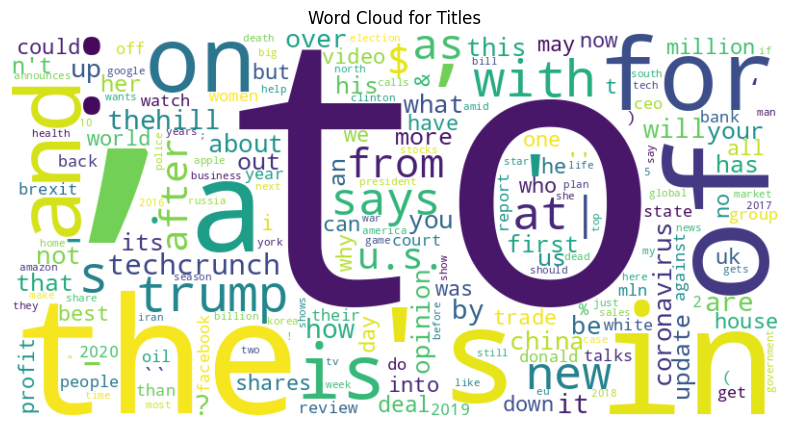

In [98]:
from wordcloud import WordCloud


title_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(title_word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Titles')
plt.show()

In [99]:
#taking a subset of articles because of the huge volume of words
df_subset = df.head(9000)

article_tokens = [word for article in df_subset['article'] for word in word_tokenize(article.lower())]
article_word_freq = Counter(article_tokens)

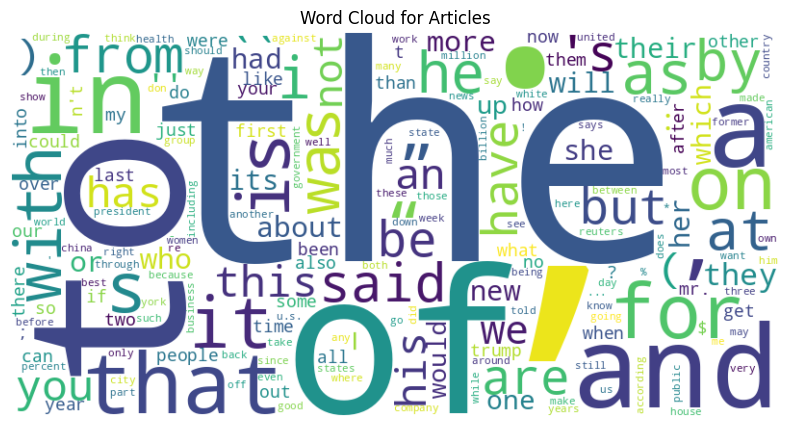

In [100]:
article_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(article_word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(article_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Articles')
plt.show()

In [101]:
#importing cleaned dataframe
df.to_csv('/content/drive/MyDrive/BA820_Project/cleaned_data.csv')